## Difference between langchain and langgraph

### Workflow example with steps
- find best flight based on price cap of $1500

- once flight is booked book the best hotel within price range of less than $1500

- once both flight and hotel are booked, I want to create my travel plan but while planning i want to use my friend's travel plan as a reference.

### If we want to implement this workflow with langchain
- I will create an agent with tools like 1) flight search, 2) hotel search, 3) Agentic RAG-based travel planner using a chaining process.

- Issues in this flow:
    - once a failure happens, the process fails
    - lack of parallelism
    - lack of conditional loop we can not go back and forth at step level
    - to cover this limitation, we can have `if .. else ` loop but that makes our code complicated
- this can easily be overcome if we use graphs

### if we implement the same using graph
- we would use the same tools but after output of each tool we would check if the condition is met, if not we would go back to the tool and try to find a better solution. e.g. i want to book a flight, and if the resulting flight is costlier than $1500, i will try to go back to search and find a different flight till I find which is less than $1500 or a finite number of retry.
- This can be termed as ReACT decision-making at each tool.
- This process is more natural and reliable to code then `if .. else` condition
- We can also have state persistence, which makes it easier to share informtion between in each tool call, allowing more flexibility to get response and does not need manual process.

### langchain vs langgraph
- langchain is ideal for llm application where more linear operation are required.  langgraph is ideal for a non-linear process where we have condition blocks for decision-making and going to different flow based on it.
- langchain uses a linear chain structure like DAG, and langgraph uses graph like structure with loops.
- langchain includes memory, prompt, llm and agent as building blocks while langgraph uses nodes, edges and state.
- langchain has limited state persistence, langgraph has consistent state management out of box

### how does langgraph actually work?
- langgraph uses node, edges, state as building blocks
    - State:
        - user defined and maintained
        - passed between nodes
        - can be in local or persistent storage
    - Nodes:
        - represents individual processing functions
        - e.g., llm calling, tool call/mcp/api call
        - generally python functions or code blocks
        - Responsible for processing input, generating output and maintaining state
    - Edges:
        - defines possible transition between steps
        - they connect nodes and specify paths which a node can take
        - there can be only two type of edge 1) direct, 2) conditional
- state graph
    - when nodes, state and edges are connected its called state graph
    - it is a container that holds the complete logic and flow of the processes
    - it holds the entire agentic workflow
    - so basically, its a representation which shows how the information flows through the application

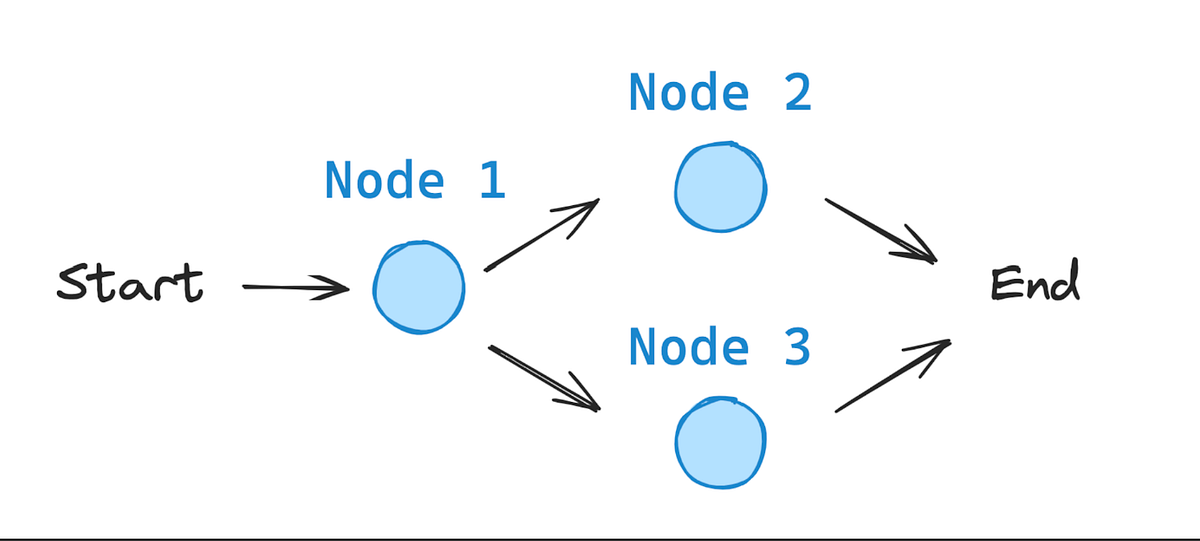

### Use Case—1 Email Sorter and responder
- Get content of email or multiple email as input
- Identify the email is `spam` or `not a spam` and label it
- if its `spam` discard the email
- if its `not a spam` send confirmation of email received and share a summary of email to manager to take action

### converting use case requirement to langgraph building blocks
- State
    - Email
        - email content
        - email subject
        - email sender
        - email receiver
        - email label
        - email summary
        - email label reason
- Nodes
    - Read email (MCP, API Integration, document loader/file loader)
    - Classify email
    - Handle Spam
    - Draft email summary
    - notify required person via email/slack
- Edges
    - start -> Read email (`direct edge`)
    - Read email -> Classify email (`direct edge`)
        - condition 1 - spam -> handle spam (`conditional edge`)
            - handle spam -> end (`direct edge`)
        - condition 2 - not spam -> draft email summary (`conditional edge`)
            - draft email summary -> notify required person (`direct edge`)
            - notify required person -> end (`direct edge`)

### Coding the use case using langgraph, openai and huggingface

#### Setting up environment

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
from typing import TypedDict, List, Dict, Any, Optional

from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

In [ ]:
# get required environment variables
load_dotenv(find_dotenv())
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGFUSE_PUBLIC_KEY = os.getenv("PUBLIC_KEY")
LANGFUSE_SECRET_KEY = os.getenv("SECRET_KEY")
LANGFUSE_HOST = os.getenv("LANGFUSE_HOST")

In [ ]:
model = ChatOpenAI(model="gpt-4.1", temperature=0, api_key=OPENAI_API_KEY)

#### Step 1 Define our application State
It represents all the information which might be required by any node throughout the workflow.

In [ ]:
class EmailState(TypedDict):
	email: Dict[str, any]
	is_spam: Optional[bool]
	spam_reason: Optional[str]
	email_summary: Optional[str]
	email_category: Optional[str]
	messages: List[Dict[str, Any]]  # used for conversion history

#### Step 2 Define our Nodes

In [ ]:
def read_email(state: EmailState):
	"""Read email from local or persistent storage."""
	email = state["email"]
	print(
		f"Reading email: {email['subject']} from {email['sender']} to {email['receiver']}"
	)
	return {}


def classify_email(state: EmailState):
	"""Classify email as spam or not spam."""
	email = state["email"]
	prompt = f"""
You are a professional email analyst tasked with determining whether an email is spam or legitimate. Proceed as follows:

1. Examine the email fields below.
2. Output the single classification token **SPAM** or **HAM** (no additional text).
3. Immediately after the classification, on the same line, give a concise explanation in **no more than 100 words**.
   - The explanation should be a brief summary (≤ 100 words); count words, not characters.

Email:
From: {email["sender"]}
Subject: {email["subject"]}
Body:
{email["body"]}

Answer:
""".strip()
	messages = [HumanMessage(content=prompt)]
	response = model.invoke(messages)
	response_text = response.content.strip().lower()
	print(response_text)
	is_spam = "spam" in response_text and "ham" not in response_text
	if not is_spam:
		new_messages = state.get("messages", []) + [
			{"role": "user", "content": prompt},
			{"role": "assistant", "content": response.content},
		]
	else:
		new_messages = state.get("messages", [])

	return {
		"is_spam": is_spam,
		"spam_reason": response_text,
		"messages": new_messages,
	}


def handle_spam(state: EmailState):
	"""Notify about spam email."""
	print("Spam email received.")
	print(f"Reason: {state['spam_reason']}")
	return {}


def draft_email_summary(state: EmailState):
	"""Draft email summary."""
	email = state["email"]
	prompt = f"""
You are an AI summarizer. Produce a concise, professional summary of the email below in **no more than 100 words**.

Email:
From: {email["sender"]}
Subject: {email["subject"]}
Body:
{email["body"]}

Answer:
""".strip()
	messages = [HumanMessage(content=prompt)]
	response = model.invoke(messages)
	response_text = response.content.strip()
	print(response_text)
	new_messages = state.get("messages", []) + [
		{"role": "user", "content": prompt},
		{"role": "assistant", "content": response_text},
	]
	return {
		"email_summary": response_text,
		"messages": new_messages,
	}


def notify_required_person(state: EmailState):
	email = state["email"]
	print(
		f"Hello, I am your AI Agent.  You have received an email from {email['sender']}."
	)
	print("\n I have already verified that this email is not a spam.")
	print(f"Subject: {email['subject']}")
	print("\n I have prepared a short summary of the email below:")
	print("-" * 50)
	print(f"\n{state['email_summary']}")
	print("=" * 50)
	return {}


def route_email(state: EmailState) -> str:
	"""Route email to the appropriate handler."""
	if state["is_spam"]:
		return "spam"
	else:
		return "legitimate"

#### Step 3 setup graph structure
You would be able to see how intuitive it is to create structure then writing if else condition


In [ ]:
# create graph
email_graph = StateGraph(EmailState)

In [ ]:
# add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_email_summary", draft_email_summary)
email_graph.add_node("notify_person", notify_required_person)

In [ ]:
# add edges
email_graph.add_edge(START, "read_email")  # after start, read email
email_graph.add_edge("read_email", "classify_email")  # after read email, classify email

# add conditional edges
email_graph.add_conditional_edges(
	"classify_email",  # after classify email, verify email is spam or not
	route_email,
	{
		"spam": "handle_spam",  # if spam go to handle spam
		"legitimate": "draft_email_summary",  # if not spam go to draft email summary
	},
)

# add final edge
email_graph.add_edge(
	"draft_email_summary", "notify_person"
)  # after draft email summary, notify required person
email_graph.add_edge("handle_spam", END)  # after handle spam, end
email_graph.add_edge("notify_person", END)  # after notification, end

#### Step 4 compile the graph and visualize it

In [ ]:
# compile the graph
compiled_graph = email_graph.compile()

In [ ]:
# visualize the graph, to see how the nodes and edges are connected
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

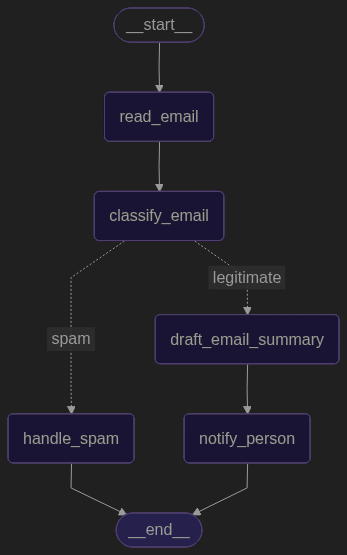
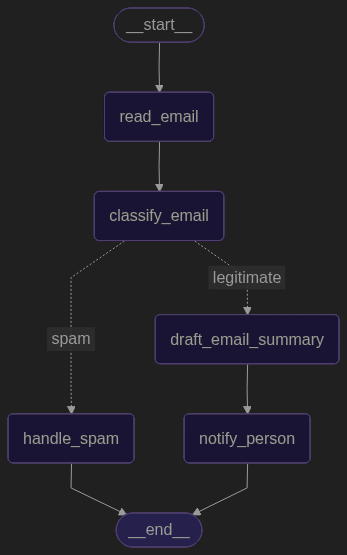

#### Note
- if you are using langgraph in production via fastapi or other such framework, we would need to run all step till compile when we first start the app.
- we do not need to run each time we want to use langgraph, unless server restarts this process is one time and can be directly used by call as shown in next steps

#### Step 5 - Test our langgraph

In [ ]:
# example emails
legitimate_email = {
	"sender": "Acme AI",
	"subject": "Potential partnership",
	"receiver": "batman",
	"body": "Hello, We have seen your work on Agents and we would like to partnership/collaborate with you.  Do let us know a good time to reach you!",
}
spam_email = {
	"sender": "Crypto bro",
	"subject": "Important Message",
	"receiver": "batman",
	"body": "hello, i have just launched the biggest and bested crypto coin with gurantee to double your investment in 3 months. Click on link to buy now!!!!",
}

In [ ]:
# run the example through our graph
response = compiled_graph.invoke(
	{
		"email": legitimate_email,
		"is_spam": None,
		"spam_reason": None,
		"email_summary": None,
		"email_category": None,
		"messages": [],
	}
)

In [ ]:
response = compiled_graph.invoke(
	{
		"email": spam_email,
		"is_spam": None,
		"spam_reason": None,
		"email_summary": None,
		"email_category": None,
		"messages": [],
	}
)

#### Step 6 Integrating with Langfuse
- It allows us to easily debug the Langgraph functionality during development
- Langfuse provides robust tracability for future monitoring and analysis when we want to deploy our application to production

***for any agent development, it is important to have evaluation and observability***


In [ ]:
# Setup langfuse client
from langfuse import Langfuse

langfuse = Langfuse(
	secret_key=os.getenv("SECRET_KEY"),
	public_key=os.getenv("PUBLIC_KEY"),
	host=os.getenv("LANGFUSE_HOST"),
)

In [ ]:
from langfuse import get_client

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
	print("Langfuse client is authenticated and ready!")
else:
	print("Authentication failed. Please check your credentials and host.")

In [ ]:
# setup langgraph and langfuse
from langfuse.langchain import CallbackHandler

langfuse_handler = CallbackHandler()

In [ ]:
# test the application again with langfuse integrated
response = compiled_graph.invoke(
	{
		"email": legitimate_email,
		"is_spam": None,
		"spam_reason": None,
		"email_summary": None,
		"email_category": None,
		"messages": [],
	},
	config={"callbacks": [langfuse_handler]},
)

In [ ]:
response = compiled_graph.invoke(
	{
		"email": spam_email,
		"is_spam": None,
		"spam_reason": None,
		"email_summary": None,
		"email_category": None,
		"messages": [],
	},
	config={"callbacks": [langfuse_handler]},
)